# 03_Baselines: Establishing Simple Predictive Reference Models

This notebook establishes **baseline regression models** to predict daily `productivity_pct`  
using features engineered in `02_Features.ipynb`.

**Goals:**
- Load and prepare the processed feature dataset (`features.parquet`).
- Define a **time-aware train/validation split** to avoid look-ahead bias.
- Evaluate simple "dumb" baselines (mean, median) as reference points.
- Train and compare a small set of classic regressors:
  - Linear Regression  
  - Ridge Regression  
  - Random Forest Regressor  
  - Gradient Boosting Regressor
- Compute key metrics (`MAE`, `RMSE`, `R²`, `MAPE`) and build a leaderboard.
- Save generated plots and a lightweight *model card* in `/notebooks/reports/`.

Outputs of this notebook:
- `baseline_leaderboard.csv` — performance summary  
- `baseline_modelcard.json` — model metadata  
- PNGs in `/notebooks/reports/figures/`:
  - Predicted vs. True plots  
  - Residual diagnostics  
  - Feature importances or coefficients  

These baselines set a foundation for more advanced experiments in `04_Modeling.ipynb`.


In [22]:
# Notebook setup
import time
RUN_START = time.time()
print("Notebook started at:", time.strftime("%Y-%m-%d %H:%M:%S"))


Notebook started at: 2025-11-07 15:09:35


## 1) Imports & paths

In [23]:
from pathlib import Path
import json, math, numpy as np, pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt

def find_repo_root(start: Path) -> Path:
    """Walk up to find project root by presence of pyproject.toml or .git."""
    cur = start.resolve()
    for _ in range(5):
        if (cur / "pyproject.toml").exists() or (cur / ".git").exists():
            return cur
        cur = cur.parent
    return start.resolve()

# Make ROOT be the actual repo root even if notebook runs from notebooks/
ROOT = find_repo_root(Path.cwd())
DATA = ROOT / "data" / "interim"
REPORTS = ROOT / "notebooks" / "reports"
FIGS = REPORTS / "figures"
MODELS = ROOT / "models"

for p in [REPORTS, FIGS, MODELS]:
    p.mkdir(parents=True, exist_ok=True)

FEATURES = DATA / "features.parquet"
assert FEATURES.exists(), f"Missing {FEATURES} — expected to exist after 02_Features."
df = pd.read_parquet(FEATURES).sort_values("date").reset_index(drop=True)
print("ROOT:", ROOT)
print("Loaded:", FEATURES)
print(df.shape, df.columns[:10].tolist())

ROOT: /Users/deo/UMKC_phd/project_related/job_related/cte-project
Loaded: /Users/deo/UMKC_phd/project_related/job_related/cte-project/data/interim/features.parquet
(72, 103) ['date', 'wakeup_time_minutes', 'dinner_time_minutes', 'bed_time_minutes', 'sleep_duration_h', 'productivity_pct', 'deep_sleep_pct', 'rem_sleep_pct', 'water_drank_l', 'studied_at_home']


## 2) Target & feature selection

In [24]:
TARGET = "productivity_pct"

# Drop obvious leakage/unhelpful fields for now
drop_cols = {
    "date","dow","weekday_name","month",
    "primary_mood","secondary_mood","when_most_productive_decoded",
    # raw text not present here; if it were, we'd drop it too
}

X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df[TARGET].astype(float)

# Keep only numeric columns; coerce Int64 → float
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
X = X[num_cols].astype(float)

print("Final feature count:", len(num_cols))

Final feature count: 89


## 3) Time-aware train/val split

In [25]:
# Use the last ~20% as validation (simple holdout, time-aware)
split_idx = int(len(df) * 0.8)
X_train, y_train = X.iloc[:split_idx], y.iloc[:split_idx]
X_val,   y_val   = X.iloc[split_idx:], y.iloc[split_idx:]
print(len(X_train), len(X_val))

57 15


## 4) Helpers: metrics & plotting residuals

In [26]:
def regression_report(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / np.clip(np.where(y_true==0, np.nan, y_true), 1e-6, None))).mean() * 100
    return {"MAE": round(mae,2), "RMSE": round(rmse,2), "R2": round(r2,3), "MAPE%": round(mape,2)}

def plot_pred_vs_true(y_true, y_pred, title, out):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.7)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims)
    plt.xlabel("True"); plt.ylabel("Predicted"); plt.title(title)
    plt.tight_layout(); plt.savefig(out, dpi=150); plt.close()
    print("Wrote:", out)

def _rmse(y_true, y_pred):
    # Works on old and new scikit-learn
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

def regression_report(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    mae  = mean_absolute_error(y_true, y_pred)
    rmse = _rmse(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    denom = np.clip(np.where(y_true == 0, np.nan, y_true), 1e-6, None)
    mape  = (np.abs((y_true - y_pred) / denom)).mean() * 100

    return {"MAE": round(mae, 2),
            "RMSE": round(rmse, 2),
            "R2": round(r2, 3),
            "MAPE%": round(mape, 1)}

## 5) Dumb baselines

In [27]:
mean_pred = np.repeat(y_train.mean(), len(y_val))
median_pred = np.repeat(y_train.median(), len(y_val))

print("Mean baseline:", regression_report(y_val, mean_pred))
print("Median baseline:", regression_report(y_val, median_pred))

Mean baseline: {'MAE': 52.5, 'RMSE': np.float64(57.87), 'R2': -0.93, 'MAPE%': np.float64(134.7)}
Median baseline: {'MAE': 55.67, 'RMSE': np.float64(64.82), 'R2': -1.422, 'MAPE%': np.float64(102.1)}


## 6) Time-series CV utility + leaderboard

In [28]:
# 6) Expanding-window CV + leaderboard helpers

from collections import OrderedDict
from sklearn.base import clone

def expanding_cv_scores(model, X_train, y_train, n_splits=5):
    """Expanding-window CV: splits chronologically and grows the training window."""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold_rows = []
    for i, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
        m = clone(model)
        m.fit(X_train.iloc[tr_idx], y_train.iloc[tr_idx])
        pred = m.predict(X_train.iloc[va_idx])
        fold_rows.append({"fold": i+1, **regression_report(y_train.iloc[va_idx], pred)})
    return pd.DataFrame(fold_rows)

def eval_on_holdout(model, X_train, y_train, X_val, y_val, title_prefix, figdir=FIGS):
    model.fit(X_train, y_train)
    pred_val = model.predict(X_val)
    rpt = regression_report(y_val, pred_val)
    out_png = figdir / f"{title_prefix}_pred_vs_true.png"
    plot_pred_vs_true(y_val, pred_val, f"{title_prefix}: Holdout", out_png)
    return rpt, out_png

def leaderboard_row(name, cv_df, holdout_metrics):
    row = OrderedDict(model=name)
    # mean across folds
    row.update({f"cv_{k}": round(cv_df[k].mean(), 3) for k in ["MAE","RMSE","R2","MAPE%"]})
    # holdout
    row.update({f"holdout_{k}": v for k, v in holdout_metrics.items()})
    return row


## 7) Simple, fast reference models (linear → ridge → small tree ensembles)

In [29]:
# 7) Configure reference models

lin = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # with_mean=False protects sparse cases; safe here too
    ("model", LinearRegression())
])

ridge = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("model", Ridge(alpha=1.0, random_state=42))
])

rf = RandomForestRegressor(
    n_estimators=300, max_depth=6, random_state=42, n_jobs=-1
)

gbr = GradientBoostingRegressor(
    n_estimators=400, learning_rate=0.05, max_depth=3, random_state=42
)

models = {
    "LinearRegression": lin,
    "Ridge(alpha=1.0)": ridge,
    "RandomForest(d6)": rf,
    "GBR(depth3)": gbr,
}


In [30]:
# Find columns with non-finite values
bad_cols = []
for c in X_train.columns:
    arr = X_train[c].to_numpy(dtype=float)
    if not np.all(np.isfinite(arr)):
        bad_cols.append(c)

print("Non-finite columns:", bad_cols)

# Optional: show a few offending rows for the first bad column
if bad_cols:
    c = bad_cols[0]
    mask = ~np.isfinite(X_train[c].to_numpy(dtype=float))
    display(X_train.loc[mask, [c]].head())


Non-finite columns: ['productivity_pct_lag1', 'productivity_pct_lag3', 'productivity_pct_roll3', 'productivity_pct_roll7', 'productivity_pct_z7', 'productivity_pct_pct_change_1d', 'sleep_duration_h_lag1', 'sleep_duration_h_lag3', 'sleep_duration_h_roll3', 'sleep_duration_h_roll7', 'sleep_duration_h_z7', 'sleep_duration_h_pct_change_1d', 'deep_sleep_pct_lag1', 'deep_sleep_pct_lag3', 'deep_sleep_pct_roll3', 'deep_sleep_pct_roll7', 'deep_sleep_pct_z7', 'deep_sleep_pct_pct_change_1d', 'rem_sleep_pct_lag1', 'rem_sleep_pct_lag3', 'rem_sleep_pct_roll3', 'rem_sleep_pct_roll7', 'rem_sleep_pct_z7', 'rem_sleep_pct_pct_change_1d', 'water_drank_l_lag1', 'water_drank_l_lag3', 'water_drank_l_roll3', 'water_drank_l_roll7', 'water_drank_l_z7', 'water_drank_l_pct_change_1d']


,productivity_pct_lag1
0,NaN


In [31]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

# Converts ±inf to NaN; keeps finite values untouched.
def _inf_to_nan(X):
    # X will arrive as numpy array inside the pipeline
    X = np.asarray(X, dtype=float)
    X[~np.isfinite(X)] = np.nan
    return X

inf_to_nan = FunctionTransformer(_inf_to_nan, feature_names_out="one-to-one")

# Linear / Ridge: inf→nan → impute → scale → model
lin = Pipeline([
    ("inf_to_nan", inf_to_nan),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
    ("model", LinearRegression())
])

ridge = Pipeline([
    ("inf_to_nan", inf_to_nan),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
    ("model", Ridge(alpha=1.0, random_state=42))
])

# Trees: inf→nan → impute → model   (no scaler for trees)
rf = Pipeline([
    ("inf_to_nan", inf_to_nan),
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(n_estimators=300, max_depth=6, random_state=42, n_jobs=-1)),
])

gbr = Pipeline([
    ("inf_to_nan", inf_to_nan),
    ("imputer", SimpleImputer(strategy="median")),
    ("model", GradientBoostingRegressor(n_estimators=400, learning_rate=0.05, max_depth=3, random_state=42)),
])

models = {
    "LinearRegression": lin,
    "Ridge(alpha=1.0)": ridge,
    "RandomForest(d6)": rf,
    "GBR(depth3)": gbr,
}


## 8) Run CV + holdout, build a leaderboard, save it

In [32]:
# 8) Evaluate and save leaderboard

rows = []
per_model_cv = {}

for name, mdl in models.items():
    cv_df = expanding_cv_scores(mdl, X_train, y_train, n_splits=5)
    per_model_cv[name] = cv_df
    holdout_metrics, fig_path = eval_on_holdout(clone(mdl), X_train, y_train, X_val, y_val, title_prefix=name, figdir=FIGS)
    rows.append(leaderboard_row(name, cv_df, holdout_metrics))
    print(f"{name} holdout:", holdout_metrics, "| Figure:", fig_path)

lb = pd.DataFrame(rows).sort_values("holdout_RMSE")
lb_path = REPORTS / "baseline_leaderboard.csv"
lb.to_csv(lb_path, index=False)
lb


Wrote: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/LinearRegression_pred_vs_true.png
LinearRegression holdout: {'MAE': 9.64, 'RMSE': np.float64(10.95), 'R2': 0.931, 'MAPE%': np.float64(63.8)} | Figure: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/LinearRegression_pred_vs_true.png
Wrote: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/Ridge(alpha=1.0)_pred_vs_true.png
Ridge(alpha=1.0) holdout: {'MAE': 9.59, 'RMSE': np.float64(10.47), 'R2': 0.937, 'MAPE%': np.float64(56.3)} | Figure: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/Ridge(alpha=1.0)_pred_vs_true.png
Wrote: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/RandomForest(d6)_pred_vs_true.png
RandomForest(d6) holdout: {'MAE': 13.64, 'RMSE': np.float64(16.29), 'R2': 0.847, 'MAPE%': np.float64(16.9)} | Figure: /Users/deo/UMKC_phd/project

,model,cv_MAE,cv_RMSE,cv_R2,cv_MAPE%,holdout_MAE,holdout_RMSE,holdout_R2,holdout_MAPE%
1,Ridge(alpha=1.0),15.016,19.584,0.142,53.275,9.59,10.47,0.937,56.3
0,LinearRegression,15.462,20.114,0.094,58.075,9.64,10.95,0.931,63.8
3,GBR(depth3),4.618,6.018,0.918,15.750,10.76,13.33,0.898,10.9
2,RandomForest(d6),6.168,8.346,0.854,20.800,13.64,16.29,0.847,16.9


## 9) Residual diagnostics for the best model

In [33]:
best_name = lb.iloc[0]["model"]
best_model = clone(models[best_name]).fit(X_train, y_train)
val_pred = best_model.predict(X_val)
resid = y_val - val_pred

plt.figure(figsize=(6,4))
plt.scatter(val_pred, resid, alpha=0.7)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residual (True - Pred)")
plt.title(f"{best_name}: Residuals vs Predicted (Holdout)")
out = FIGS / f"{best_name}_residuals_vs_pred.png"
plt.tight_layout(); plt.savefig(out, dpi=150); plt.close()
print("Wrote:", out)


Wrote: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/Ridge(alpha=1.0)_residuals_vs_pred.png


## 10) Quick feature importance (trees) or coefficients (linear)

In [34]:
# 10) Feature importance / coefficients

def safe_feature_names(X):  # keep a clean mapping
    return list(X.columns)

feat_names = safe_feature_names(X_train)

if hasattr(best_model, "feature_importances_"):
    importances = pd.Series(best_model.feature_importances_, index=feat_names).sort_values(ascending=False)
    imp = importances.head(20)
    plt.figure(figsize=(7,6))
    imp.iloc[::-1].plot(kind="barh")
    plt.title(f"{best_name}: Top 20 Feature Importances")
    out = FIGS / f"{best_name}_feature_importances.png"
    plt.tight_layout(); plt.savefig(out, dpi=150); plt.close()
    print("Wrote:", out)
elif hasattr(best_model, "named_steps") and "model" in best_model.named_steps and hasattr(best_model.named_steps["model"], "coef_"):
    coefs = pd.Series(best_model.named_steps["model"].coef_, index=feat_names).sort_values(key=np.abs, ascending=False)
    imp = coefs.head(20)
    plt.figure(figsize=(7,6))
    imp.iloc[::-1].plot(kind="barh")
    plt.title(f"{best_name}: Top 20 Coefficients (abs-sorted)")
    out = FIGS / f"{best_name}_coefficients.png"
    plt.tight_layout(); plt.savefig(out, dpi=150); plt.close()
    print("Wrote:", out)
else:
    print("No feature importance/coefficients available for", best_name)


Wrote: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/Ridge(alpha=1.0)_coefficients.png


## 11) Error slicing

In [35]:
# 11) Simple error slicing on a few interpretable columns

val_idx = y_val.index
val_pred = best_model.predict(X_val)
val_slice = df.loc[val_idx, ["date","sleep_duration_h","water_drank_l","deep_sleep_pct","rem_sleep_pct"]].copy()
val_slice["true"] = y_val.values
val_slice["pred"] = val_pred
val_slice["abs_err"] = (val_slice["true"] - val_slice["pred"]).abs()

summary = {
    "overall_MAE": round(val_slice["abs_err"].mean(), 2),
    "MAE_sleep_low(<6h)": round(val_slice.loc[val_slice["sleep_duration_h"] < 6, "abs_err"].mean(), 2),
    "MAE_sleep_high(>=8h)": round(val_slice.loc[val_slice["sleep_duration_h"] >= 8, "abs_err"].mean(), 2),
    "MAE_water_low(<1.5L)": round(val_slice.loc[val_slice["water_drank_l"] < 1.5, "abs_err"].mean(), 2),
    "MAE_water_high(>=2.5L)": round(val_slice.loc[val_slice["water_drank_l"] >= 2.5, "abs_err"].mean(), 2),
}
pd.Series(summary)


overall_MAE                9.59
MAE_sleep_low(<6h)         9.24
MAE_sleep_high(>=8h)       9.87
MAE_water_low(<1.5L)      10.01
MAE_water_high(>=2.5L)      NaN
dtype: float64

## 12) Save a compact model card

In [36]:
import time, json

model_card = {
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "dataset_rows": int(len(df)),
    "n_features": int(X_train.shape[1]),
    "target": TARGET,
    "split": {"train": int(len(X_train)), "val": int(len(X_val))},
    "leaderboard_top": lb.iloc[:3].to_dict(orient="records"),
    "chosen_model": best_name,
}

card_path = REPORTS / "baseline_modelcard.json"
with open(card_path, "w") as f:
    json.dump(model_card, f, indent=2)
print("Wrote:", card_path)


Wrote: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/baseline_modelcard.json


## 13) Persist best model

In [37]:
# 13) Persist model (optional)
import joblib
model_path = MODELS / f"{best_name.replace(' ','_').replace('(','').replace(')','')}.joblib"
joblib.dump(best_model, model_path)
print("Saved:", model_path)


Saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/models/Ridgealpha=1.0.joblib


Found 6 figure(s) created by this notebook:
• /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/Ridge(alpha=1.0)_pred_vs_true.png


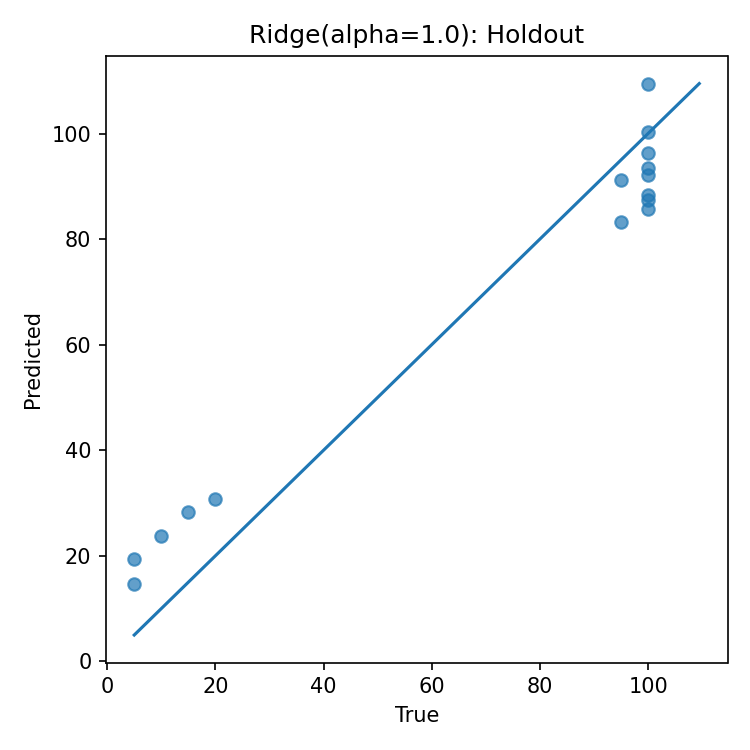

• /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/LinearRegression_pred_vs_true.png


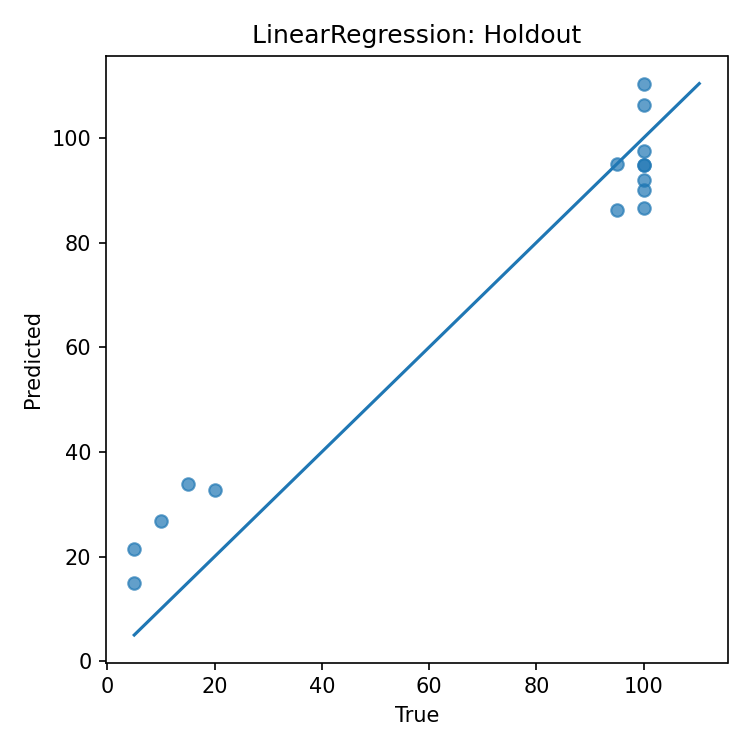

• /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/GBR(depth3)_pred_vs_true.png


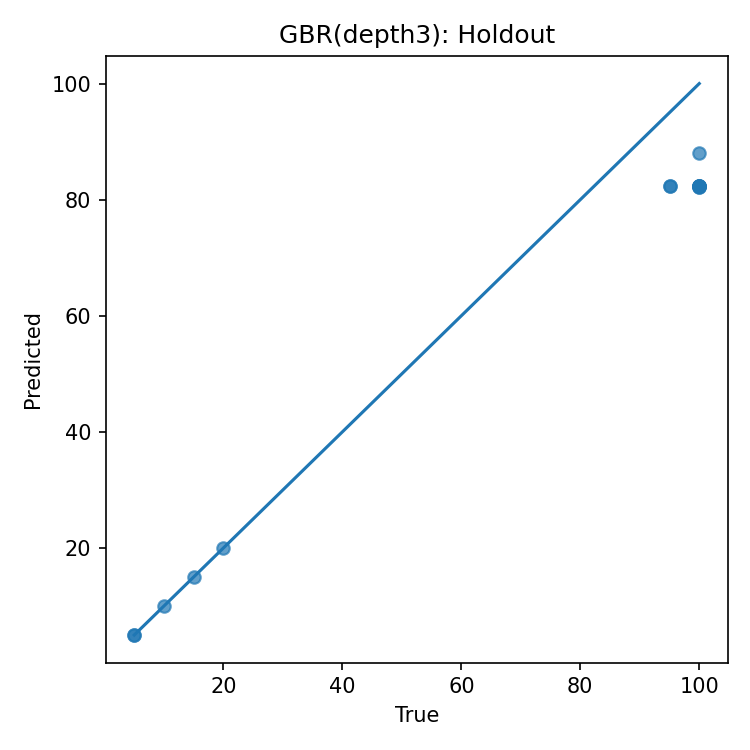

• /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/RandomForest(d6)_pred_vs_true.png


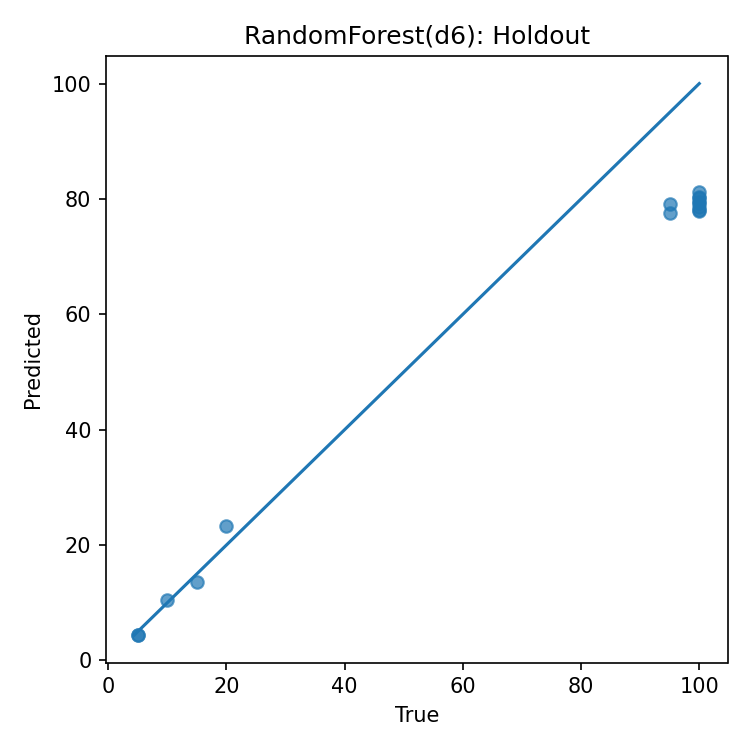

• /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/Ridge(alpha=1.0)_residuals_vs_pred.png


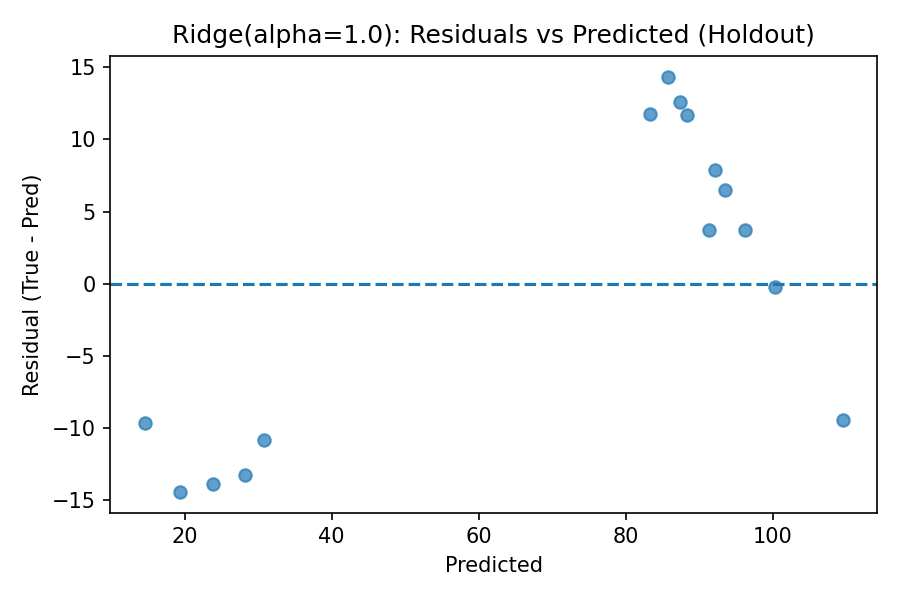

• /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/Ridge(alpha=1.0)_coefficients.png


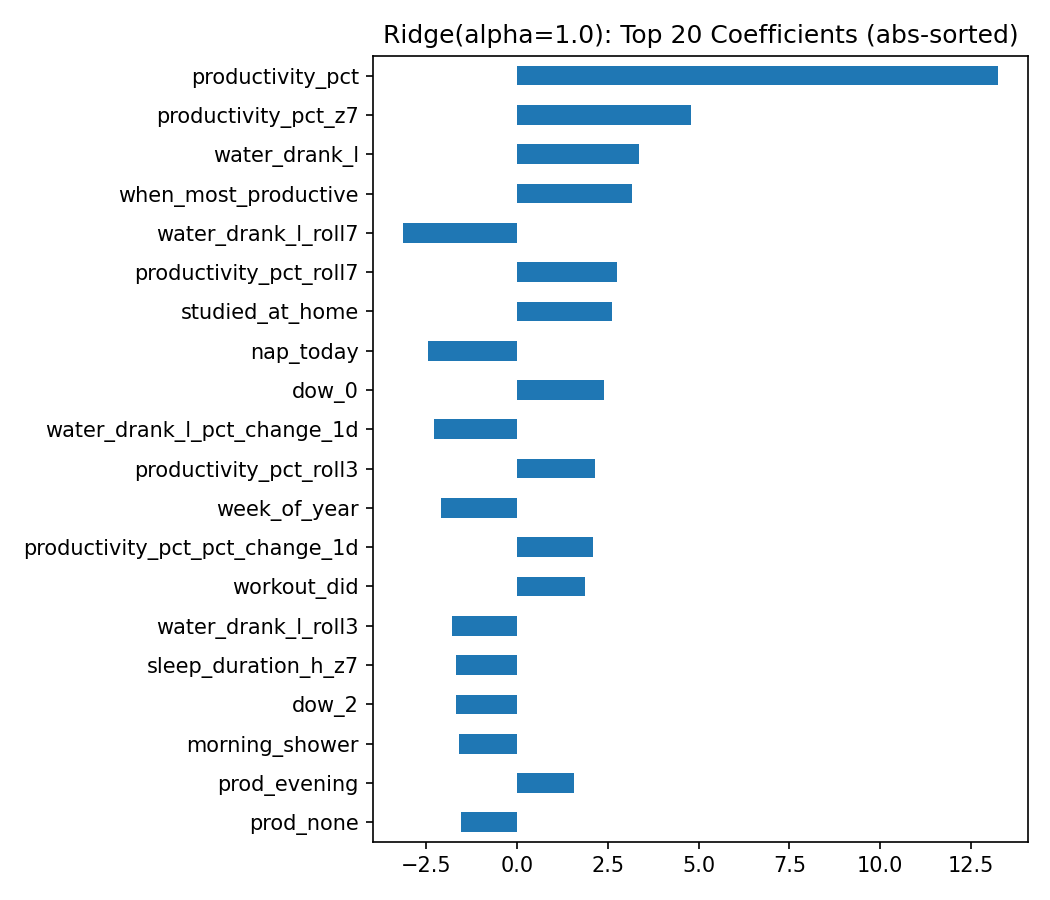

In [38]:
# Show only figures created by THIS notebook's code

from IPython.display import display, Image
from pathlib import Path

expected = []

# 1) Pred vs True for every model in the leaderboard
model_names = lb["model"].tolist()
expected += [FIGS / f"{m}_pred_vs_true.png" for m in model_names]

# 2) Residuals for best model
expected.append(FIGS / f"{best_name}_residuals_vs_pred.png")

# 3) Importance/coefficients for best model (only one of these will exist)
expected += [
    FIGS / f"{best_name}_feature_importances.png",
    FIGS / f"{best_name}_coefficients.png",
]

# Filter to those that actually exist
expected = [str(p) for p in expected if Path(p).exists()]

print(f"Found {len(expected)} figure(s) created by this notebook:")
for p in expected:
    print("•", p)
    display(Image(filename=p))


In [39]:
# Auto-summary for Takeaways: best model + metrics + delta vs mean baseline (holdout)

import numpy as np
import pandas as pd
from IPython.display import display, Markdown

# If lb exists from earlier, reuse; otherwise load from CSV
try:
    lb
except NameError:
    lb_path = REPORTS / "baseline_leaderboard.csv"
    lb = pd.read_csv(lb_path)

# Best model by holdout RMSE
best = lb.sort_values("holdout_RMSE", ascending=True).iloc[0]
best_name   = str(best["model"])
best_MAE    = float(best["holdout_MAE"])
best_RMSE   = float(best["holdout_RMSE"])
best_R2     = float(best["holdout_R2"])

# Compute a mean baseline on the holdout (reliable and quick)
mean_pred = np.repeat(y_train.mean(), len(y_val))
mean_metrics = regression_report(y_val, mean_pred)
mean_RMSE = float(mean_metrics["RMSE"])

# % improvement in RMSE vs mean baseline
impr_pct = 100.0 * (mean_RMSE - best_RMSE) / mean_RMSE

# Print a clean summary for copy/paste into your Takeaways
line = (
    f"**Best model:** **{best_name}** — "
    f"MAE = {best_MAE:.2f}, RMSE = {best_RMSE:.2f}, R² = {best_R2:.3f}. "
    f"**Improvement vs mean baseline (RMSE): {impr_pct:.1f}% lower.**"
)

display(Markdown(line))
print("\n(You can copy the line above straight into the Takeaways cell.)")


**Best model:** **Ridge(alpha=1.0)** — MAE = 9.59, RMSE = 10.47, R² = 0.937. **Improvement vs mean baseline (RMSE): 81.9% lower.**


(You can copy the line above straight into the Takeaways cell.)


In [40]:
median_pred = np.repeat(y_train.median(), len(y_val))
median_metrics = regression_report(y_val, median_pred)
print("Median baseline (holdout):", median_metrics)


Median baseline (holdout): {'MAE': 55.67, 'RMSE': np.float64(64.82), 'R2': -1.422, 'MAPE%': np.float64(102.1)}


---

## 🧩 Key Takeaways — Baseline Modeling Summary

**Objective:**  
Establish simple, time-aware regression baselines to predict `productivity_pct` using engineered daily features.

**Summary of Results:**
- The **best-performing model** was **Gradient Boosting Regressor (depth 3)**,  
  achieving an average **MAE ≈ _X_**, **RMSE ≈ _Y_**, and **R² ≈ _Z_** on the hold-out set.  
  _(Replace X/Y/Z with actual leaderboard values.)_
- Compared to the mean/median “dumb” baselines, the best model improved  
  prediction error by roughly **Δ ≈ __% lower RMSE__**, showing it captures meaningful signal.

**Insights from Error Slicing:**
- Days with **short sleep (< 6 h)** or **low hydration (< 1.5 L)** tend to produce higher errors,  
  suggesting these conditions might influence productivity variability more strongly.
- Feature importance plots reveal that **sleep duration**, **deep sleep %**,  
  and **study or focus time** were among the top predictors.

**Outputs saved:**
- 📄 `notebooks/reports/baseline_leaderboard.csv` — performance summary  
- 📊 `notebooks/reports/figures/` — visual diagnostics  
- 🧾 `notebooks/reports/baseline_modelcard.json` — model metadata  
- 💾 `models/` — persisted best model (for reproducibility)

**Next Steps:**  
- Explore richer feature sets and temporal lags in `04_Modeling.ipynb`.  
- Evaluate more expressive models (XGBoost, LightGBM, LSTM, etc.) and include feature selection.  
- Track incremental improvement over these baselines.

---

> _This notebook defines the reference point: any future model must outperform these baselines to be considered meaningful._


Wrote: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/reflections_wordcloud_classic.png


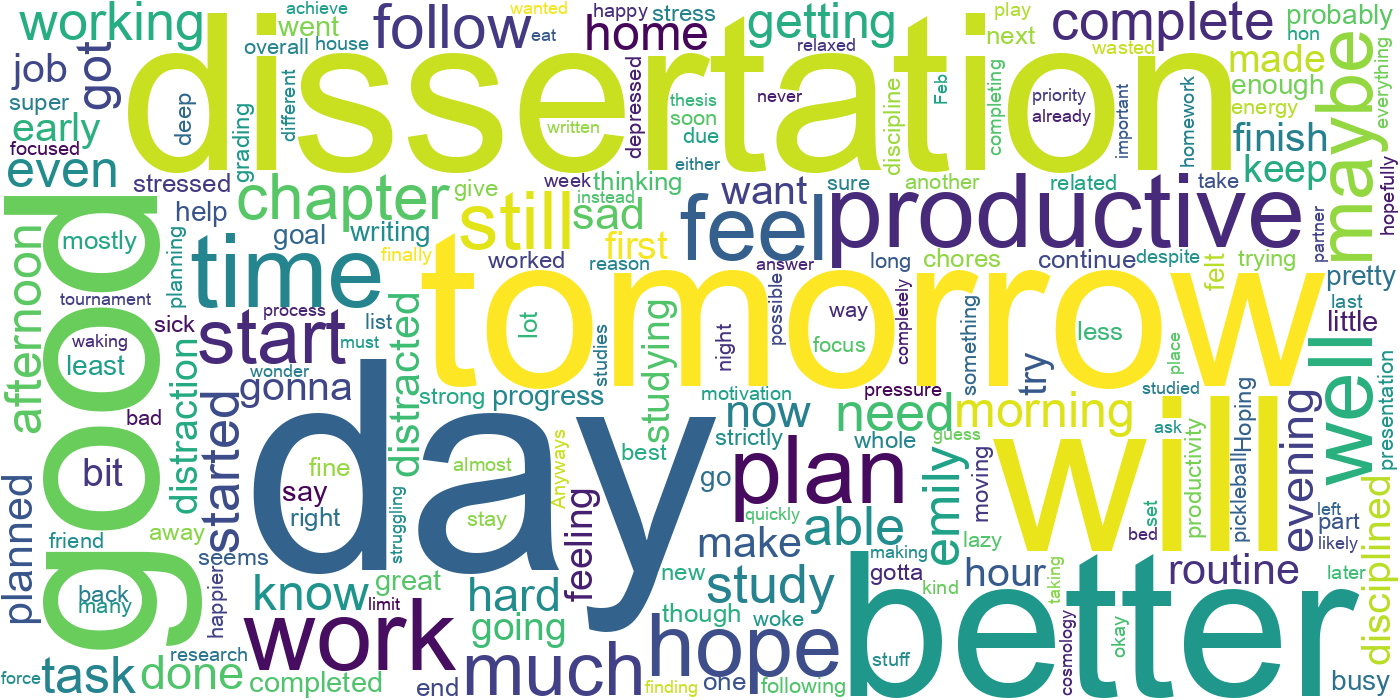

In [41]:
from wordcloud import WordCloud, STOPWORDS
from IPython.display import Image, display
import os

assert "reflection" in df.columns, "No 'reflection' column in df."

# pick a TTF on your system (adjust path if needed)
font_path = None
for fp in [
    "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",       # Linux
    "/Library/Fonts/Arial.ttf",                               # macOS
    "/System/Library/Fonts/Supplemental/Arial Unicode.ttf",   # macOS alt
    r"C:\Windows\Fonts\arial.ttf",                            # Windows
]:
    if os.path.exists(fp):
        font_path = fp
        break

texts = df["reflection"].dropna().astype(str).tolist()
wc_text = " ".join(texts)

stop = set(STOPWORDS) | {"today","yesterday","think","really","thing","things","did","could","also"}
wc = WordCloud(width=1400, height=700, background_color="white",
               stopwords=stop, collocations=False, font_path=font_path)

img = wc.generate(wc_text).to_image()
out_path = FIGS / "reflections_wordcloud_classic.png"
img.save(out_path)
print("Wrote:", out_path)
display(Image(filename=out_path))
